In [ ]:
!pip install openmeteo-requests requests requests_cache retry_requests lxml pandas

In [11]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import matplotlib.pyplot as plt

def setup_client():
    """
    Menyiapkan client API dengan fitur Cache dan Retry.
    Tujuannya agar koneksi stabil dan hemat kuota.
    """
    # Buat cache bernama '.cache', data disimpan selama 3600 detik (1 jam)
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    
    # Jika gagal connect, coba lagi (retry) sampai 5x
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    
    # Return objek client yang siap pakai
    return openmeteo_requests.Client(session=retry_session)

In [12]:
def fetch_weather_data(client, lat, lon, start_date, end_date):
    """
    Mengirim permintaan (Request) ke server Open-Meteo.
    """
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        # Variabel yang diminta: Suhu, Kelembapan, Hujan, Tekanan
        "hourly": ["temperature_2m", "relative_humidity_2m", "rain", "surface_pressure"],
        "timezone": "Asia/Jakarta"
    }

    print(f"🚀 Mengambil data ERA5 untuk lokasi: {lat}, {lon}...")
    responses = client.weather_api(url, params=params)
    
    # Ambil respons pertama (karena kita cuma minta 1 lokasi)
    return responses[0]

In [13]:
def process_data(response):
    """
    Mengubah data mentah dari API menjadi Pandas DataFrame yang rapi.
    """
    # Akses objek Hourly (data jam-jaman)
    hourly = response.Hourly()

    # Ambil nilai per variabel (sesuai urutan request di 'params')
    # Index 0: temp, 1: humidity, 2: rain, 3: pressure
    temp = hourly.Variables(0).ValuesAsNumpy()
    humid = hourly.Variables(1).ValuesAsNumpy()
    rain = hourly.Variables(2).ValuesAsNumpy()
    press = hourly.Variables(3).ValuesAsNumpy()

    # Buat Rentang Waktu
    date_range = pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end = pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq = pd.Timedelta(seconds=hourly.Interval()),
        inclusive = "left"
    )

    # Gabungkan menjadi DataFrame
    df = pd.DataFrame(data = {
        "date": date_range,
        "temperature": temp,
        "humidity": humid,
        "rain_mm": rain,
        "pressure": press
    })

    # Atur Index Waktu & Pastikan Timezone WIB
    df = df.set_index('date')
    df.index = df.index.tz_convert('Asia/Jakarta')
    
    print(f"✅ Data berhasil diolah! Total: {len(df)} baris data.")
    return df

In [14]:
def plot_weather_data(df, title="Grafik Cuaca"):
    """
    Memvisualisasikan data Suhu vs Hujan dalam satu grafik.
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot 1: Suhu (Garis Oranye) - Sumbu Kiri
    ax1.plot(df.index, df['temperature'], color='darkorange', linewidth=2, label='Suhu (°C)')
    ax1.set_ylabel('Suhu Udara (°C)', color='darkorange', fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='darkorange')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Plot 2: Hujan (Batang Biru) - Sumbu Kanan
    ax2 = ax1.twinx()
    ax2.bar(df.index, df['rain_mm'], color='dodgerblue', alpha=0.3, width=0.04, label='Curah Hujan (mm)')
    ax2.set_ylabel('Curah Hujan (mm)', color='dodgerblue', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='dodgerblue')
    
    # Judul & Tampilan
    plt.title(title, fontsize=14, fontweight='bold')
    plt.show()

🚀 Mengambil data ERA5 untuk lokasi: -7.7365696677212705, 109.64577050600323...
✅ Data berhasil diolah! Total: 7296 baris data.
                           temperature   humidity  rain_mm     pressure
date                                                                   
2025-01-01 00:00:00+07:00    24.351000  95.306389      1.8  1007.431885
2025-01-01 01:00:00+07:00    24.250999  95.879311      0.8  1006.832458
2025-01-01 02:00:00+07:00    24.301001  96.750778      0.6  1006.134033
2025-01-01 03:00:00+07:00    24.101000  96.745987      0.2  1006.132812
2025-01-01 04:00:00+07:00    23.901001  97.620583      0.1  1005.732117


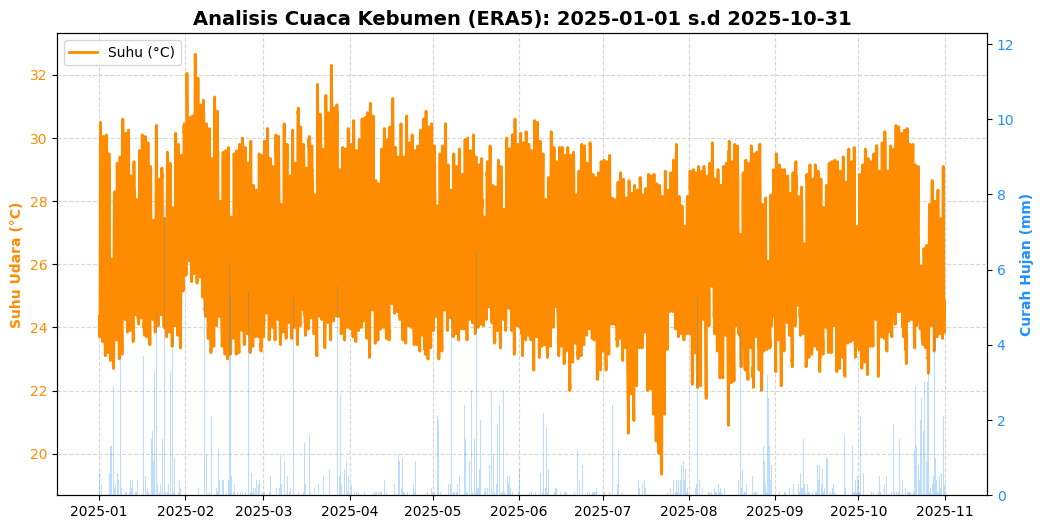

In [16]:
# --- MAIN PROGRAM ---

if __name__ == "__main__":
    # 1. Konfigurasi
    LAT_KEBUMEN = -7.7365696677212705
    LON_KEBUMEN = 109.64577050600323
    TGL_MULAI = "2025-01-01"
    TGL_AKHIR = "2025-10-31"

    # 2. Jalankan Langkah-langkah
    client_api = setup_client()                                     # Langkah 1: Setup
    raw_response = fetch_weather_data(client_api,                   # Langkah 2: Ambil Data
                                      LAT_KEBUMEN, LON_KEBUMEN, 
                                      TGL_MULAI, TGL_AKHIR)
    
    df_cuaca = process_data(raw_response)                           # Langkah 3: Olah Data
    
    # Cek data sedikit
    print(df_cuaca.head())

    # Langkah 4: Gambar Grafik
    plot_weather_data(df_cuaca, title=f"Analisis Cuaca Kebumen (ERA5): {TGL_MULAI} s.d {TGL_AKHIR}")